# MATH60629
# Semaine \#7 - Apprentissage non supervisé - Réponses aux exercices

Ce tutoriel explore deux tâches de l'apprentissage non supervisé. En premier lieu le regroupement (*clustering*) aux Section 7.2 et 7.3. Ensuite, la réduction de la dimensionnalité à la section 7.4.

Le but de ces exercices est de vous aider à mieux comprendre certaines des méthodes classiques de l'apprentissage non-supervisé (k-moyenne, mélange gaussien et les autoencodeurs). 

In [1]:
# Libraries standards
import pandas as pd
import numpy as np

# Librarie scikit-learn
import sklearn as sk
from sklearn.cluster import KMeans   # KMeans function
from sklearn.datasets import make_circles, make_blobs  # Datasets
from sklearn.model_selection import train_test_split   # Cross validation library
from sklearn import mixture

# Libraire pour la visualisation
import matplotlib.pyplot as plt
# Libraire pour des figures de meilleure qualité facilement
import seaborn as sns   
from matplotlib.pyplot import cm # choix de couleurs

%matplotlib inline

# On doit utiliser le fichier utilities.py
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week7-Unsupervised/utilities.py
!mkdir Images
!wget -nc -P Images https://raw.githubusercontent.com/lcharlin/80-629/master/week7-Unsupervised/Images/AE.png

# On importe quelques fonctions à partir de ce fichier
from utilities import color, super_scat_it, distance, initiate, estimate_centroid

%load_ext autoreload
%autoreload 2

File ‘utilities.py’ already there; not retrieving.

mkdir: Images: File exists
File ‘Images/AE.png’ already there; not retrieving.



## 7.1 Génération de données

Nous allons générer des données pour le regroupement.

Nous utiliserons la fonction [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs) de sklearn. La fonction génère simplement des données à partir d'un certain nombre des gaussiennes isotropiques (c.-à-d. sans covariance).

**Remarque**: Pour obtenir les résultats attendus à 7.2.1, veuillez ne pas modifier les paramètres de la fonction `make_blobs`.

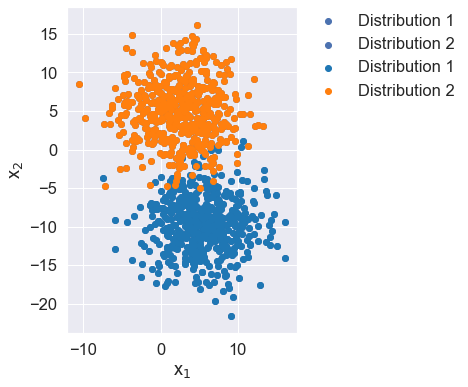

In [19]:
nb_obs = 1000 # Nombre d'observations
k = 2         # Nombre de regroupement
std = 4       # Écart type de chaque Gausienne 
dim = 2       # Dimensionnalité des données
seed = 10     # Racine pour la génération aléatoire contrôlée

X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std= std, 
                  n_features=dim, random_state=seed)   # génération des données

super_scat_it(X, y, k)   # visualisation - fonction venant de utilities.py
#super_scat_it(X, y, k, wcolor=True)   # pour visualisation des blobs

## 7.2 Regroupement: Méthode K-moyennes (K-Means)


### 7.2.1 Implémentation avec numpy

Évidemment, la méthode des K-moyennes existe dans `sklearn`, mais pour apprendre nous allons d'abord en coder une première implémentation. 

**Question 7.1**

En vous aidant du pseudo-code présenté à la [diapo 18 du cours](http://www.cs.toronto.edu/~lcharlin/courses/80-629/slides_unsupervised.pdf), veuillez compléter la fonction `fit` de la classe `k_means` ci-dessous.

**Réponse 7.1**

In [16]:
class k_means:

    def __init__(self, data, k, seed=None):
        """
        Args:
            data: données sans cible
            k: nombre de groupes
        Attributs de la classe:
            self.data: données sans cible
            self.centroid: le centre des groupes
            self.label: responsabilités (à quel centre chaque donnée appartient)
        """
        
        self.data = data
        self.centroid = initiate(data, k)
        self.label = np.argmin(distance(self.data, self.centroid ), axis=1)
            
    def fit(self):
        
        # étape 1. mise à jour du centre des groupes
        self.centroid = estimate_centroid(self.data, self.label)
        # étape 2. mise à jour des responsabilités 
        label_new = np.argmin(distance(self.data, self.centroid), axis=1)
        
        # on itère les deux étapes jusqu'à convergence
        while label_new.tolist() != self.label.tolist():
            self.label = label_new
            # étape 1.
            self.centroid = estimate_centroid(self.data, self.label)
            # étape 2.
            label_new = np.argmin(distance(self.data, self.centroid), axis=1)
                        
        self.label = label_new
        # calcul de l'objectif (moyenne des distances de chaque point à son centre)
        self.objective = np.mean(np.min(distance(self.data, self.centroid), axis=1)) 

On peut maintenant entraîner notre modèle des K-moyennes et visualiser les groupes trouvés sur les données générées plus haut.

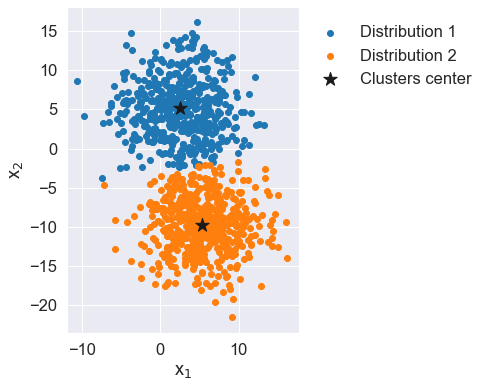

In [17]:
km = k_means(X, k)
km.fit()

super_scat_it(X, km.label, dim, km.centroid, wcolor=True)

### 7.2.2 Exploration de la méthode K-moyennes (*K-means*) de Scikit Learn

Nous allons dorénavant utiliser l'implémentation des K-moyennes de la libraire [Scikit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 

Pour commencer, on peut comparer les résultats par rapport à notre implémentation. 

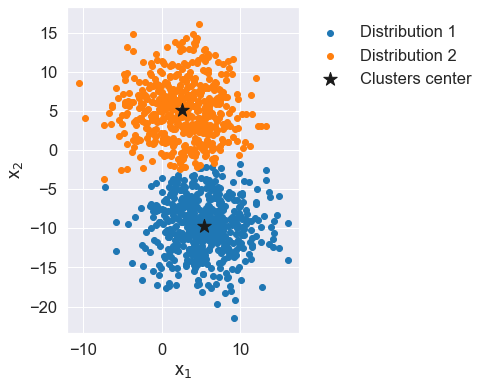

In [18]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
super_scat_it(X, kmeans.labels_, dim, kmeans.cluster_centers_, wcolor=True)

Les couleurs sont inversées, mais les résultats semblent être les mêmes. 

### 7.2.3 Trouver le nombre optimal de groupes

Quand nous utilisons des données simulées, nous connaissons le nombre de groupes (paramètre `centers` de `make_blobs`). D'habitude, nous n'avons pas ce luxe et il est donc essentiel de développer une méthodologie pour trouver le nombre de groupes requis.

**Questions 7.2**

1. Suggérez une façon simple pour déterminer le nombre optimal de groupes.
2. Implémentez là.
3. Pour les données simulées, combien de groupes votre méthode suggère-t-elle d'utiliser?

**Réponses 7.2**

1. La validation croisée peut être utilisée dans un contexte d'apprentissage non-supervisé. On peut donc augmenter le nombre de groupes jusqu'à ce que l'erreur de validation augmente ou atteigne un plateau. **Par contre**, contrairement à l'apprentissage supervisé l'erreur de validation continuera sans doute à diminuer même au-delà du k « optimal ». Il faut donc trouver quand l'augmentation du nombre de centres n'apporte pas un gain suffisamment élevé. Ça dépendra de votre application, mais en général on peut utiliser la [méthode du coude (en anglais)](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). La méthode consiste à surveiller la diminution de l'objectif en augmentant le nombre de centres et à choisir le nombre de centres avant que la « pente de l'objectif »  ne change brusquement (voir figure ci-dessous). On ajoutant quelques hypothèses sur les données on peut aussi utiliser un test d'hypothèse pour déterminer s'il est souhaitable d'augmenter $k$. Le [F-test](https://en.wikipedia.org/wiki/F-test) est souvent utilisé dans ce contexte. 

2. La validation croisée est implémentée ci-dessous. 
3. Utiliser deux groupes semble être un bon choix.

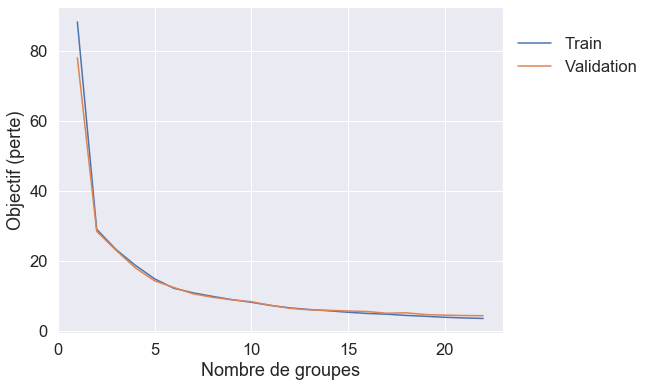

In [6]:
# on obtient un jeu de validation en divisant l'ensemble d'entraînement
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)
loss_train, loss_valid = [], []

# on entraîne un modèle pour k=1 jusqu'à max_cluster 
max_cluster = 22

for k in np.arange(max_cluster)+1:
    # on entraîne un modèle k-moyennes avec k groupes
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    # on conserve les erreurs de validation et d'entraînement
    loss_train.append(np.mean(np.min(distance(X_train, kmeans.cluster_centers_), axis=1)))
    loss_valid.append(np.mean(np.min(distance(X_valid, kmeans.cluster_centers_), axis=1)))

# on visualise les erreurs
plt.plot(np.arange(max_cluster)+1, loss_train, label='Train')
plt.plot(np.arange(max_cluster)+1, loss_valid, label='Validation')

plt.xlabel('Nombre de groupes')
plt.ylabel('Objectif (perte)')

leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .85))
leg.get_frame().set_alpha(0)

<!-- 
**Questions 7.3**

   1. Are you disappointed by the behaviour of the curve associated to the validation set?
   2. Considering the results obtained here, could you imagine a better way to know the optimal number of clusters?
   
**Answers 7.3**

   1. In hindsight it makes sense, see our justification below.
   2. Yes indeed! ***A statistical inference technique:***  The loss function considered aims at minimizing the variance within the different clusters (that's what the objective function says). Therefore, the question comes down to asking whether the addition of a new cluster sufficiently reduces the intra-cluster variance. However, under the assumption of normality of the observations, which is the case in our simulated data, we can suppose that each of the variances under study follows a chi-square distribution (!). We could therefore create a test in order to know if the sums of the chi squares, in the case where we have $k$ or $k + 1$ clusters, are significantly different. This associated test is the [F-test](https://en.wikipedia.org/wiki/F-test)!
--> 

L'exercice précédent était basé sur un jeu de données relativement simple. En effet, le jeu contenait un bon nombre d'observations ($n = 1000$) étant donné la taile de l'espace des données ($\bf{X} \in \mathbb{R}^2$) ainsi qu'un petit nombre de groupes ($k = 2$). Pour valider notre méthode de validation croisée, essayons avec un jeu de données un peu plus complexe. 

In [7]:
nb_obs = 100  # Nombre d'observations
k = 10        # Nombre de regroupement
std = 4       # Écart type de chaque Gausienne 
dim = 50      # Dimensionnalité des données
seed = 10     # Racine pour la génération aléatoire contrôlée

# Data generation
X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std= std, 
                  n_features=dim, random_state=seed)

On ne peut évidemment plus visualiser ces données qui ont 50 dimensions.

Voyons la fonction d'objectif en fonction du nombre de groupes. 

(80, 50)


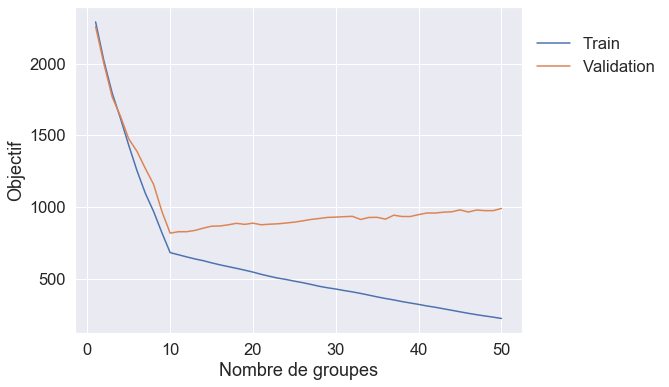

In [8]:
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)
loss_train, loss_valid = [], []
print(X_train.shape)

max_cluster = 50

for k in np.arange(max_cluster)+1:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    loss_train.append(np.mean(np.min(distance(X_train, kmeans.cluster_centers_), axis=1)))
    loss_valid.append(np.mean(np.min(distance(X_valid, kmeans.cluster_centers_), axis=1)))

plt.plot(np.arange(max_cluster)+1, loss_train, label='Train')
plt.plot(np.arange(max_cluster)+1, loss_valid, label='Validation')

plt.xlabel('Nombre de groupes')
plt.ylabel('Objectif')

# On cache la légende
leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .85))
leg.get_frame().set_alpha(0);

**Questions 7.4**

   1. Êtes-vous surpris du comportement de la courbe d'**entraînement**?
   2. Qu'en est-il de la courbe de **validation**?
    
**Réponses 7.4**

   1. La courbe diminue de monotoniquement (jusqu'à atteindre 0). C'est exactement ce à quoi on doit s'attendre. Au plus tard, quand le nombre de groupes $k$ est égal au nombre de données $n$ on aura une erreur de 0. 
   2. Selon la méthode du coude, on devrait utiliser 10 groupes. Dans ce cas, c'est aussi le nombre de blobs, donc le résultat semble correct. En pratique, assurez-vous que la fonction d'objectif (l'axe des y sur la figure) est raisonnable pour votre application. Vous pouvez aussi utiliser d'autres objectifs qui vous suggèreraient un autre nombre idéal de groupes.


## 7.3 Regroupement - Le mélange gaussien (Gaussian mixture model GMM)

Nous gardons la même tâche, mais allons utiliser une autre méthode, le mélange de gaussien et l'algorithme [Expectation Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) (EM) pour estimer les paramètres du modèle. 

Comme présenté aux [diapos 26 à 41 du cours](http://www.cs.toronto.edu/~lcharlin/courses/80-629/slides_unsupervised.pdf), le modèle peut être vu comme associant à chaque observation une probabilité d'appartenir à un groupe ou un autre (donc la responsabilité est maintenant une valeur continue entre 0 et 1).

Nous allons utiliser l'algorithme EM de l'implémentation des GMM dans sklearn&nbsp;: [sklearn GMMs](https://scikit-learn.org/0.16/modules/generated/sklearn.mixture.GMM.html)

No handles with labels found to put in legend.


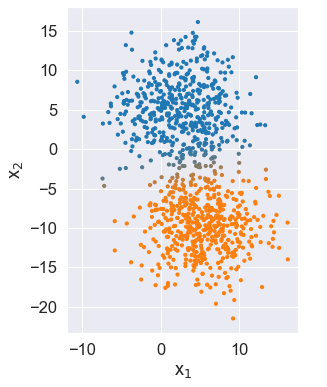

In [9]:
# comme pour les questions d'avant, nous générons quelques données avec
# la fonction make_blobs
cluster_std=4
X, y = make_blobs(n_samples=1000, centers=2, cluster_std=cluster_std, 
                  n_features=2, random_state=10)

# et puis on entraîne le modèle GMM
nb_components = 2
GMM = mixture.GaussianMixture(n_components=nb_components, 
                              covariance_type='full')
GMM.fit(X)

# On peut visualiser les résultats de regroupement. 
# La couleur de chaque point indique à quel groupe il appartient
# de manière probabiliste.
super_scat_it(X, GMM.predict_proba(X), dim=nb_components, 
              clusters_center=0, task='EM')

**Questions 7.5**

1. Qu'est-ce qui est différent sur cette figure par rapport aux résultats de la méthode K-moyennes?
2. Que se serait-il passé si on avait changé le paramètre associé à la variance de chaque blob (la sous-population) à 2? C.-à-d. `cluster_std=2`.

**Réponses 7.5**

1. Quelques observations semblent être assignées aux deux groupes en même temps. C'est un des avantages de la méthode GMM par rapport à la méthode des K-moyennes.
2. Essayez-le!

### 7.3.1 Choisir le nombre optimal de groupes pour la méthode de mélange gaussien

**Questions 7.6**

1. Comment trouver le bon nombre de groupes?
2. Les courbes d'entraînement et validation se comportent-elles comme dans le cas de la méthode des K-moyennes (Section 7.2.3)? ?

**Réponses 7.6**

1. Comme précédemment, nous pouvons utiliser la validation croisée avec le modèle GMM (voir notre code ci-dessous).
2. Le modèle GMM est un modèle probabiliste. Il maximise donc la log-vraissemblance. Cela dit, le comportement des courbes d'entraînement et validation est similaire de leur comportement avec la méthode des K-moyennes. Dans la figure ci-dessous, on voit que l'objectif d'entraînement augmente pour des nombres de groupes plus élevés alors que l'erreur de validation atteint un maximum global pour $k = 2$.


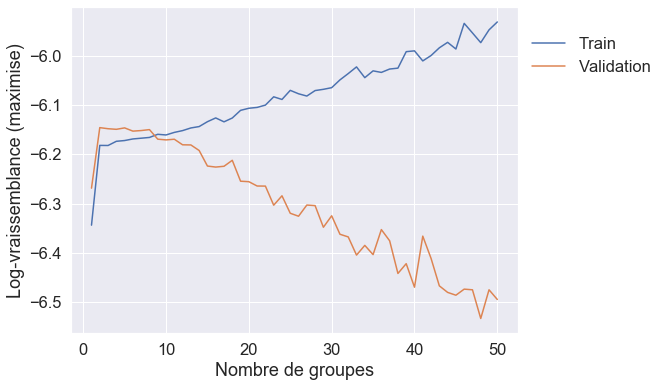

In [10]:
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)
loss_train, loss_valid = [], []

for k in np.arange(max_cluster)+1:
    GMM = mixture.GaussianMixture(n_components=k, covariance_type='full')
    GMM.fit(X_train)
    
    loss_train.append(GMM.score(X_train))
    loss_valid.append(GMM.score(X_valid))
            
plt.plot(np.arange(max_cluster)+1, loss_train, label='Train')
plt.plot(np.arange(max_cluster)+1, loss_valid, label='Validation')

plt.xlabel('Nombre de groupes')
plt.ylabel('Log-vraissemblance (maximise)')

# Ghosting the legend
leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .85))
leg.get_frame().set_alpha(0)

## 7.4 Réduction de la dimensionnalité: Autoencodeur

### 7.4.1 Modèle

Les auto-encodeurs (AE) sont un type de réseau de neurones *feed-forward* pour l'apprentissage non supervisé. Voir (capsules 4 de la semaine 7 ou le [Chapitre 14](http://www.deeplearningbook.org/contents/autoencoders.html) du livre [Deep Learning book](http://www.deeplearningbook.org/)). Pour y arriver, l'AE est entraîné à prédire ou copier les données en entrée. Il existe plusieurs types d'AE, la figure ci-dessous en représente un AE&nbsp;:

![title](./Images/AE.png)

L'AE contient donc un encodeur:
$$
\begin{align}
    h(\mathbf{x}) = \frac{1}{1+ \exp(-\mathbf{W} \mathbf{x})}.
\end{align}
$$

qui prend en entrée une observation et réduit sa dimensionnalité. Ensuite, le décodeur:

$$
\begin{align}
    f(h(\mathbf{x})) = \mathbf{W}^\top h(\mathbf{x})
\end{align}
$$

essaie <i>de reconstruire</i> l'observation donnée à partir de la représentation cachée. Cet AE, tente donc d'estimer les observations. Pour y arriver, la couche cachée doit donc contenir une *compression* de l'observation pour que le décodeur puisse la décompresser. 

### 7.4.2 Génération de données

Nous générons des données pour les AE à partir de la fonction `make_blobs`.

In [11]:
nb_obs = 10**4  # Nombre d'observations
k = 3           # Nombre de regroupement
std = 0.01      # Écart type de chaque Gausienne 
dim = 5         # Dimensionnalité des données
seed = 10       # Racine pour la génération aléatoire contrôlée

X, y = make_blobs(n_samples=nb_obs, centers=k, cluster_std=std, 
                  n_features=dim, random_state=10)   # Data generation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

**!! Remarque !!** 

Les autoencodeurs n'existent pas directement dans sklearn, mais comme ce sont des réseaux feed forward nous pouvons utiliser la classe `MLP` pour construire un AE.

Notez qu'il existe aussi une libraire nommé `scikit-neuralnetwork` qui offre les [modèles AE](https://scikit-neuralnetwork.readthedocs.io/en/latest/guide_sklearn.html#unsupervised-pre-training) directement et une interface proche de celle de `scikit-learn`. 

In [12]:
import warnings # pour nous éviter des warning de sklearn
warnings.filterwarnings("ignore")

from sklearn.neural_network import MLPRegressor

learning_rate = 1e-1
aenn = MLPRegressor(hidden_layer_sizes=(2), 
             activation='logistic', 
             solver='adam', 
             alpha=0.0001, 
             batch_size='auto', 
             early_stopping=True,
             learning_rate_init=learning_rate,
             verbose=True)

# Comme on utilise le early_stopping de sklearn,
# on concatène nos ensembles d'entraînement et de validation
aenn.fit(np.vstack((X_train, X_valid)), np.vstack((X_train, X_valid)))

# Si on veut utiliser notre ensemble de validation originale
# on peut utiliser la fonction partial_fit()
# Par exemple,
#from sklearn.metrics import mean_squared_error
#max_epochs = 100 
#mse_train, mse_valid = [], []
#for i in range(max_epochs):
#    aenn.partial_fit(X_train, X_train)
#    train_pred = aenn.predict(X_train)
#    mse_train.append(mean_squared_error(X_train, train_pred))
#
#    valid_pred = aenn.predict(X_valid)
#    mse_valid.append(mean_squared_error(X_valid, valid_pred))

Iteration 1, loss = 12.80011406
Validation score: 0.599106
Iteration 2, loss = 5.20123636
Validation score: 0.831697
Iteration 3, loss = 2.31293877
Validation score: 0.921834
Iteration 4, loss = 1.08644512
Validation score: 0.963636
Iteration 5, loss = 0.50116741
Validation score: 0.983505
Iteration 6, loss = 0.22155975
Validation score: 0.992989
Iteration 7, loss = 0.09170714
Validation score: 0.997219
Iteration 8, loss = 0.03530740
Validation score: 0.998989
Iteration 9, loss = 0.01259447
Validation score: 0.999658
Iteration 10, loss = 0.00427805
Validation score: 0.999893
Iteration 11, loss = 0.00146141
Validation score: 0.999968
Iteration 12, loss = 0.00060088
Validation score: 0.999990
Iteration 13, loss = 0.00035918
Validation score: 0.999996
Iteration 14, loss = 0.00029786
Validation score: 0.999997
Iteration 15, loss = 0.00028358
Validation score: 0.999997
Iteration 16, loss = 0.00028069
Validation score: 0.999997
Iteration 17, loss = 0.00028018
Validation score: 0.999997
Itera

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=2, learning_rate='constant',
             learning_rate_init=0.1, max_fun=15000, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

**Question 7.7**

Pourquoi la dimension de la couche cachée doit-elle être plus petite que la dimension des entrées?

**Réponse 7.7**

Une utilisation des AE est d'apprendre une représentation qui capture l'essence des données. Cette représentation est offerte par les activations de la couche cachée. 

Si la dimension de la couche cachée était aussi grande que celle des données, ça rendrait le AE inutile. En effet, il pourrait simplement apprendre à copier les données de l'entrée à la sortie. En ayant, une plus petite couche cachée, le réseau doit apprendre une représentation qui lui permet de retrouver (prédire) les données originales.

### 7.4.4 Étude de la représentation apprise

Maintenant que nous avons entraîné notre AE, nous pouvons visualiser les représentations apprises. Nous utiliserons le fait que la couche cachée de notre AE contient seulement deux neurones pour visualiser cette représentation en deux dimensions.

Pour nous aider à interpréter les résultats, la couleur de chaque point représente le blob duquel il vient (voir `make_blobs`). 

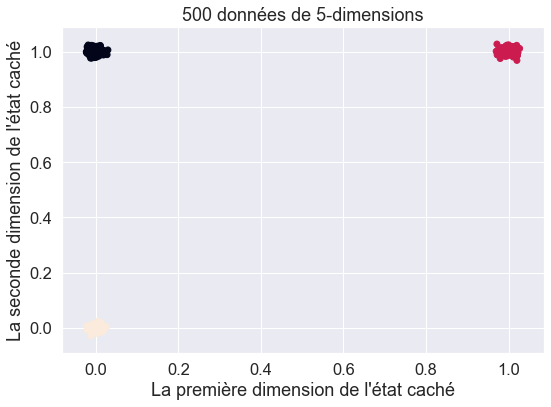

In [13]:
n_sub = 500 # on utilise un sous-ensemble de 500 données

from scipy.special import expit

X_sub = X_train[0:n_sub]
y_sub = y_train[0:n_sub]

# On obtient leur représentation cachée 
hiddens = expit(np.dot(X_sub, aenn.coefs_[0]) + aenn.intercepts_[0])

# Visualization
fig = plt.figure()
hiddens += np.random.randn(n_sub,2)*0.01 # ajouter du bruit pour la visualisation
plt.scatter(hiddens[:, 1], hiddens[:, 0], c=y_sub)
#plt.set_title("h$_1$ vs h$_2$")
plt.xlabel("La première dimension de l'état caché")
plt.ylabel("La seconde dimension de l'état caché")
plt.title('%d données de %d-dimensions' % (X_sub.shape))
plt.tight_layout()

**Questions 7.8**

1. Que notez-vous sur la figure? 
<!-- 2. Run the same experiment again without changing the hyperparameters. What do you notice? Does the latent representation seems to have changed?-->
2. La figure aurait-elle été différente si vous aviez simulé des données venant de 2 blobs plutôt que 3? Qu'en est-il si les blogs sont plus larges? Essayez! 
3. Comment pourriez-vous utiliser l'information apprise dans la couche cachée?

**Réponses 7.8**

1. La représentation cachée semble avoir encodé qu'il y avait en effet 3 groupes de données.
<!-- 2. There is a good chance that it does! We can just see it by looking at the new figures above. -->
2. Tout à fait! Vous auriez sans doute obtenu deux groupes sur la figure. Par contre, en utilisant plus de groupes vous verrez rapidement que le réseau est limité. Vous pourriez tenter d'ajouter des couches cachées pour augmenter sa performance.
3. Il y a plusieurs utilisations possibles. Vous pourriez par exemple, voir l'AE comme une technique de regroupement. Vous pourriez aussi utiliser ces représentations à la place des données dans des modèles subséquents. L'avantage est que ces nouvelles données ont maintenant moins de dimensions.